<a href="https://colab.research.google.com/github/swapnanilsharma/temp/blob/main/Epsilon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, auc,roc_auc_score, precision_recall_fscore_support, confusion_matrix, f1_score

In [ ]:
import numpy as np
a = [1, "abc", 2.5]
a

In [ ]:
# Read the data
df = pd.read_csv("/content/drive/MyDrive/Data.csv")
df.shape

(944468, 8)

In [ ]:
# Drop datapoints which are having empty data
df = df.dropna(how='any',axis=0) 
df.shape

(732567, 9)

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
# Data Preparation
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%Y-%m-%d %H:%M:%S')
df['InvoiceDate'].head()

0   2009-12-01 07:45:00
1   2009-12-01 07:45:00
2   2009-12-01 07:45:00
3   2009-12-01 07:45:00
4   2009-12-01 07:45:00
Name: InvoiceDate, dtype: datetime64[ns]

In [ ]:
df['month_wise'] = [date.year*100 + date.month for date in df.InvoiceDate]
df['day_wise'] = [date.year*10000 + date.month *100 + date.day for date in df.InvoiceDate]

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,month_wise,day_wise
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,200912,20091201
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,20091201
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,20091201
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,200912,20091201
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,200912,20091201


In [ ]:
df['CustomerSpend'] = df.Price * df.Quantity
# df['Postage'] = np.where(df.StockCode == 'POST', 'Postage','No_Postage')
# df['UK'] = np.where(df.Country == 'United Kingdom', 1,0)
df['c'] = df.Invoice.str[0]
df.loc[df.c != 'C','c'] = 'p' # setting df['c'] as 'p' for a purchase transection
data_cancel = df[df.c == 'C']
data_purch = df[df.c == 'p']

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,month_wise,day_wise,CustomerSpend,c
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,200912,20091201,83.4,p
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,20091201,81.0,p
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,20091201,81.0,p
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,200912,20091201,100.8,p
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,200912,20091201,30.0,p


In [ ]:
# creating temporal features

# Num invoices/Customer/month
Num_Invoices1 = df.groupby(['Customer ID','month_wise'], as_index =False)['Invoice'].aggregate(pd.Series.nunique)
Num_Invoices1.rename(columns = {'Invoice':'Count_All_Invoice'}, inplace = True)

Num_Purch_Invoices1 = data_purch.groupby(['Customer ID','month_wise'], as_index =False)['Invoice'].aggregate(pd.Series.nunique)
Num_Purch_Invoices1.rename(columns = {'Invoice':'Count_Purch_Invoice'}, inplace = True)

Num_Cancel_Invoices1 = data_cancel.groupby(['Customer ID','month_wise'], as_index =False)['Invoice'].aggregate(pd.Series.nunique)
Num_Cancel_Invoices1.rename(columns = {'Invoice':'Count_Cancel_Invoice'}, inplace = True)

# avg Invoices in a day /Customer/month
Num_Daily_Invoices = df.groupby(['Customer ID','month_wise','day_wise'], as_index =False)['Invoice'].aggregate(pd.Series.nunique)
Num_Daily_Purch_Invoices = data_purch.groupby(['Customer ID','month_wise','day_wise'], as_index =False)['Invoice'].aggregate(pd.Series.nunique)
Num_Daily_Cancel_Invoices = data_cancel.groupby(['Customer ID','month_wise','day_wise'], as_index =False)['Invoice'].aggregate(pd.Series.nunique)

Num_Daily_Net_Purch_Invoices = pd.merge(Num_Daily_Purch_Invoices, Num_Daily_Cancel_Invoices, how = 'outer', on = ['Customer ID','month_wise','day_wise'], suffixes = ['_Purch','_Cancel'] )

Num_Daily_Net_Purch_Invoices.fillna(0, inplace = True)

Num_Daily_Net_Purch_Invoices['Invoice_Net_Purch'] = Num_Daily_Net_Purch_Invoices.Invoice_Purch - Num_Daily_Net_Purch_Invoices.Invoice_Cancel
Avg_Daily_Invoices = Num_Daily_Net_Purch_Invoices.groupby(['Customer ID','month_wise'], as_index =False).aggregate({'Invoice_Purch':np.mean,'Invoice_Cancel':np.mean,'Invoice_Net_Purch':np.mean})
Avg_Daily_Invoices.rename(columns = {'Invoice_Purch':'Dly_avg_Count_Purch_Invoice', 'Invoice_Cancel' :'Dly_avg_Count_Cancel_Invoice', 'Invoice_Net_Purch' : 'Dly_avg_Count_Net_Purch_Invoice'}, inplace = True)

# Total Spend/month
Tot_Purch_spend = data_purch.groupby(['Customer ID' , 'month_wise'] , as_index =False)['spend'].agg(sum)
Tot_Purch_spend.rename(columns = {'spend':'Tot_Purch_spend'}, inplace = True)

Tot_Cancel_spend =  data_cancel.groupby(['Customer ID' , 'month_wise'] , as_index =False)['spend'].agg(sum)
Tot_Cancel_spend.rename(columns = {'spend':'Tot_Cancel_spend'}, inplace = True)

Tot_Net_spend =  df.groupby(['Customer ID' , 'month_wise'] , as_index =False)['spend'].agg(sum)
Tot_Net_spend.rename(columns = {'spend':'Tot_Net_spend'}, inplace = True)


# Avg Spend/Invoice
Tot_Daily_Purch_spend = data_purch.groupby(['Customer ID','month_wise','day_wise'], as_index =False)['spend'].aggregate(sum)
Tot_Daily_Cancel_spend = data_cancel.groupby(['Customer ID','month_wise','day_wise'], as_index =False)['spend'].aggregate(sum)
Tot_Daily_Net_spend = pd.merge(Tot_Daily_Purch_spend, Tot_Daily_Cancel_spend, how = 'outer', on = ['Customer ID','month_wise','day_wise'], suffixes = ['_Purch','_Cancel'] )


Tot_Daily_Net_spend.fillna(0, inplace = True)

Tot_Daily_Net_spend['Net_spend'] = Tot_Daily_Net_spend.spend_Purch + Tot_Daily_Net_spend.spend_Cancel

Avg_Daily_Net_spend = Tot_Daily_Net_spend.groupby(['Customer ID','month_wise'], as_index =False).aggregate({'spend_Purch':np.mean,'spend_Cancel':np.mean,'Net_spend':np.mean})
Avg_Daily_Net_spend.rename(columns = {'spend_Purch':'Avg_Dly_Purch_Spend', 'spend_Cancel': 'Avg_Dly_Cancel_Spend','Net_spend' : 'Avg_Dly_Net_Spend'}, inplace = True)

# cancel/Purch ratio (month level)
cancel_purch_ratio = Tot_Daily_Net_spend.groupby(['Customer ID','month_wise'], as_index= False).agg({'spend_Purch':sum,'spend_Cancel':sum,'Net_spend':sum})

cancel_purch_ratio['c_p_ratio'] = np.abs(cancel_purch_ratio.spend_Cancel / cancel_purch_ratio.spend_Purch)

cancel_purch_ratio.loc[cancel_purch_ratio.c_p_ratio.isin(['inf']),'c_p_ratio'] = 0
cancel_purch_ratio.rename(columns = {'spend_Purch':'Tot_Purch_spend', 'spend_Cancel':'Tot_Cancel_spend', 'Net_spend':'Tot_Net_spend'}, inplace = True)

# postage/spend in Purchases
postage_purch =  data_purch.groupby(['Customer ID', 'month_wise', 'Postage'], as_index = False)['spend'].agg(sum)

postage_purch1 = pd.pivot_table(postage_purch, values = ['spend'] , index = ['Customer ID', 'month_wise'],columns=['Postage'], aggfunc= sum, fill_value=0)
postage_purch1.reset_index(inplace = True)
postage_purch1.columns = ['Customer ID', 'month_wise', 'Spend_Items','Spend_Postage']

postage_purch1['Post_Spend_ratio'] = postage_purch1['Spend_Postage'] / postage_purch1['Spend_Items']

postage_purch1.loc[postage_purch1.Post_Spend_ratio.isin(['inf']),'Post_Spend_ratio'] = 0
# postage/spend in cancellations
postage_cancel =  data_cancel.groupby(['Customer ID', 'month_wise', 'Postage'], as_index = False)['spend'].agg(sum)

postage_cancel1 = pd.pivot_table(postage_cancel, values = ['spend'] , index = ['Customer ID', 'month_wise'],columns=['Postage'], aggfunc= sum, fill_value=0)
postage_cancel1.reset_index(inplace = True)
postage_cancel1.columns = ['Customer ID', 'month_wise', 'Spend_Items','Spend_Postage']
postage_cancel1['Post_Spend_ratio'] = np.abs(postage_cancel1['Spend_Postage'] / postage_cancel1['Spend_Items'])

postage_cancel1.loc[postage_cancel1.Post_Spend_ratio.isin(['inf']),'Post_Spend_ratio'] = 0

# Number of items in each invoice
Tot_Invoice_Purch_items = data_purch.groupby(['Customer ID','month_wise','Invoice'], as_index =False)['Quantity'].aggregate(sum)
Tot_Invoice_Cancel_items = data_cancel.groupby(['Customer ID','month_wise','Invoice'], as_index =False)['Quantity'].aggregate(sum)
Tot_Invoice_Net_items = pd.merge(Tot_Invoice_Purch_items, Tot_Invoice_Cancel_items, how = 'outer', on = ['Customer ID','month_wise','Invoice'], suffixes = ['_Purch','_Cancel'] )

Tot_Invoice_Net_items.fillna(0, inplace = True)

Tot_Invoice_Net_items['Net_Quantity'] = Tot_Invoice_Net_items.Quantity_Purch + Tot_Invoice_Net_items.Quantity_Cancel

Avg_Invoice_Net_items = Tot_Invoice_Net_items.groupby(['Customer ID','month_wise'], as_index =False).aggregate({'Quantity_Purch':np.mean,'Quantity_Cancel':np.mean,'Net_Quantity':np.mean})
Avg_Invoice_Net_items.rename(columns = {'Quantity_Purch':'Avg_Dly_Purch_Quantity', 'Quantity_Cancel': 'Avg_Dly_Cancel_Quantity','Net_Quantity' : 'Avg_Dly_Net_Quantity'}, inplace = True)

Avg_Invoice_Net_items['Items_retention_ratio'] = Avg_Invoice_Net_items['Avg_Dly_Net_Quantity'] / Avg_Invoice_Net_items['Avg_Dly_Purch_Quantity']

Avg_Invoice_Net_items.loc[Avg_Invoice_Net_items.Items_retention_ratio.isin(['inf', '-inf']),'Items_retention_ratio'] = 0

#creating a DF that defines the structure of input data

cust = list(set(list(df['Customer ID'].unique())))
months = df['month_wise'].unique()
month_wise = []
for i in range(0, len(cust)):
    for j in months:
        month_wise.append(j)

cust1 = [c for c in cust for k in range(0, len(months))]
cust_month = pd.DataFrame({'Customer ID': cust1, 'month_wise':month_wise})

#calculating months since last purchase


cust_month['month_last_purch'] = 190001

for cust in tqdm(cust):
    purch_month_list = list(Num_Purch_Invoices1.loc[Num_Purch_Invoices1['Customer ID'] == cust,'month_wise'])
    
    purch_month_list.append(201111)
    for i in range(len(purch_month_list)-1):
        #print (i)
        start = purch_month_list[i]
        end = purch_month_list[i+1]
        #print("range = >=", start,"<",end)        
        
        cust_month.loc[(cust_month['Customer ID'] == cust) & (cust_month.month_wise >= start) & (cust_month.month_wise < end), 'month_last_purch'] = start
        
        
cust_month['month_wise1'] = [str(x)[0:4]+str('-') + str(x)[4:6]+str('-')+str('01') for x in cust_month.month_wise]
        
cust_month['month_last_purch1'] = [str(x)[0:4]+str('-') + str(x)[4:6]+str('-')+str('01') for x in cust_month.month_last_purch]

cust_month['month_wise1'] = pd.to_datetime(cust_month['month_wise1'])        
cust_month['month_last_purch1'] = pd.to_datetime(cust_month['month_last_purch1'])    

cust_month['months_since_last_purch'] = cust_month.month_wise1 - cust_month.month_last_purch1

cust_month['months_since_last_purch1'] = [x.days/30 for x in cust_month.months_since_last_purch]
cust_month['months_since_last_purch1'] = cust_month['months_since_last_purch1'].round(0)
cust_month.loc[cust_month.months_since_last_purch1> 100, 'months_since_last_purch1'] = 999
   
cust_month = cust_month[['Customer ID', 'month_wise', 'months_since_last_purch1']]

cust_month.columns = ['Customer ID', 'month_wise', 'months_since_last_purch']

#Merging the data
combined_df = pd.merge(Num_Invoices1, Num_Purch_Invoices1,how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'] )
combined_df = pd.merge(combined_df, Num_Cancel_Invoices1,how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'] )
combined_df = pd.merge(cust_month , combined_df, how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'] )

combined_df['Count_Net_Purch_Invoice'] = combined_df.Count_Purch_Invoice - combined_df.Count_Cancel_Invoice

#merging new feature set 2 (Daily average counts)
combined_df = pd.merge(combined_df, Avg_Daily_Invoices ,how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'])

#merging new feature set 3 (Spend Variables)
combined_df = pd.merge(combined_df, Avg_Daily_Net_spend ,how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'] )

#Merging feature set 4(Total spend and cancel : spend ratio)
combined_df = pd.merge(combined_df, cancel_purch_ratio ,how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'] )

#merging new feature set 5 (Postage Variables)
combined_df = pd.merge(combined_df, postage_purch1 ,how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'] )

#merging new feature set 6 (Postage on cancellations)
combined_df = pd.merge(combined_df, postage_cancel1 ,how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'], suffixes = ['_on_Purch','_on_Cancel'])

#merging new feature set 7 (Avg_Invoice_Net_items)
combined_df = pd.merge(combined_df, Avg_Invoice_Net_items ,how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'])

#Filling all NA with 0
combined_df.fillna(0, inplace =True)

combined_df.replace([np.inf, -np.inf], 0, inplace=True)

#removing Data of 1st month (as it has only 9 days of Data)
min_month = combined_df.month_wise.unique()[0]
combined_df = combined_df[combined_df.month_wise != min_month]

100%|██████████| 5780/5780 [00:55<00:00, 103.68it/s]


In [ ]:
combined_df.head()

,Customer ID,month_wise,months_since_last_purch,Count_All_Invoice,Count_Purch_Invoice,Count_Cancel_Invoice,Count_Net_Purch_Invoice,Dly_avg_Count_Purch_Invoice,Dly_avg_Count_Cancel_Invoice,Dly_avg_Count_Net_Purch_Invoice,...,Spend_Items_on_Purch,Spend_Postage_on_Purch,Post_Spend_ratio_on_Purch,Spend_Items_on_Cancel,Spend_Postage_on_Cancel,Post_Spend_ratio_on_Cancel,Avg_Dly_Purch_Quantity,Avg_Dly_Cancel_Quantity,Avg_Dly_Net_Quantity,Items_retention_ratio
1,12346.0,200912,0.0,7.0,7.0,0.0,0.0,2.333333,0.000000,2.333333,...,158.50,0.0,0.0,0.0,0.0,0.0,5.142857,0.000000,5.142857,1.0
2,12346.0,201001,0.0,3.0,2.0,1.0,1.0,0.666667,0.333333,0.333333,...,45.00,0.0,0.0,-103.5,0.0,0.0,3.333333,-0.333333,3.000000,0.9
3,12346.0,201002,0.0,1.0,1.0,0.0,0.0,1.000000,0.000000,1.000000,...,27.05,0.0,0.0,0.0,0.0,0.0,5.000000,0.000000,5.000000,1.0
4,12346.0,201003,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
5,12346.0,201004,2.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0


In [ ]:
combined_df.columns

Index(['Customer ID', 'month_wise', 'months_since_last_purch',
       'Count_All_Invoice', 'Count_Purch_Invoice', 'Count_Cancel_Invoice',
       'Count_Net_Purch_Invoice', 'Dly_avg_Count_Purch_Invoice',
       'Dly_avg_Count_Cancel_Invoice', 'Dly_avg_Count_Net_Purch_Invoice',
       'Avg_Dly_Purch_Spend', 'Avg_Dly_Cancel_Spend', 'Avg_Dly_Net_Spend',
       'Tot_Purch_spend', 'Tot_Cancel_spend', 'Tot_Net_spend', 'c_p_ratio',
       'Spend_Items_on_Purch', 'Spend_Postage_on_Purch',
       'Post_Spend_ratio_on_Purch', 'Spend_Items_on_Cancel',
       'Spend_Postage_on_Cancel', 'Post_Spend_ratio_on_Cancel',
       'Avg_Dly_Purch_Quantity', 'Avg_Dly_Cancel_Quantity',
       'Avg_Dly_Net_Quantity', 'Items_retention_ratio'],
      dtype='object')

In [ ]:
Tot_Net_spend

,Customer ID,month_wise,Tot_Net_spend
0,12346.0,200912,158.50
1,12346.0,201001,-58.50
2,12346.0,201002,27.05
3,12346.0,201006,-173.29
4,12346.0,201009,-5.50
...,...,...,...
25098,18287.0,201005,1071.61
25099,18287.0,201009,892.60
25100,18287.0,201011,381.50
25101,18287.0,201105,765.28


In [ ]:
Tot_Daily_Net_spend

,Customer ID,month_wise,day_wise,spend_Purch,spend_Cancel,Net_spend
0,12346.0,200912,20091205,90.0,0.00,90.00
1,12346.0,200912,20091209,23.5,0.00,23.50
2,12346.0,200912,20091226,45.0,0.00,45.00
3,12346.0,201001,20100105,22.5,0.00,22.50
4,12346.0,201001,20100113,22.5,0.00,22.50
...,...,...,...,...,...,...
35750,18280.0,201011,20101115,0.0,-15.70,-15.70
35751,18282.0,201107,20110731,0.0,-1.45,-1.45
35752,18284.0,201009,20100927,0.0,-25.00,-25.00
35753,18286.0,201006,20100615,0.0,-108.00,-108.00


In [ ]:
for cust in tqdm(cust1):
    Purchase_month_list = list(Num_Purch_Invoices1.loc[Num_Purch_Invoices1['Customer ID'] == cust,'month_wise'])
    print(Purchase_month_list)
    break
    Purchase_month_list.append(201111)
    for i in range(len(Purchase_month_list)-1):
        start = Purchase_month_list[i]
        end = Purchase_month_list[i+1]      
        cust_month.loc[(cust_month['Customer ID'] == cust) & (cust_month.month_wise >= start) & (cust_month.month_wise < end), 'month_last_Purchase'] = start

  0%|          | 0/138720 [00:00<?, ?it/s]

[200912, 201001, 201002, 201006, 201101]


In [ ]:
cust_month['month_wise1'] = [str(x)[0:4]+str('-') + str(x)[4:6]+str('-')+str('01') for x in cust_month.month_wise]
        
cust_month['month_last_Purchase1'] = [str(x)[0:4]+str('-') + str(x)[4:6]+str('-')+str('01') for x in cust_month.month_last_Purchase]

cust_month['month_wise1'] = pd.to_datetime(cust_month['month_wise1'])        
cust_month['month_last_Purchase1'] = pd.to_datetime(cust_month['month_last_Purchase1'])    

cust_month['months_since_last_Purchase'] = cust_month.month_wise1 - cust_month.month_last_Purchase1

cust_month['months_since_last_Purchase1'] = [x.days/30 for x in cust_month.months_since_last_Purchase]
cust_month['months_since_last_Purchase1'] = cust_month['months_since_last_Purchase1'].round(0)
cust_month.loc[cust_month.months_since_last_Purchase1> 100, 'months_since_last_Purchase1'] = 999
   
cust_month = cust_month[['Customer ID', 'month_wise', 'months_since_last_Purchase1']]

cust_month.columns = ['Customer ID', 'month_wise', 'months_since_last_Purchase']

ParserError: ignored

In [ ]:
[str(x)[0:4]+str('-') + str(x)[4:6]+str('-')+str('01') for x in cust_month.month_wise]

['2009-11-01',
 '2009-12-01',
 '2010-01-01',
 '2010-02-01',
 '2010-03-01',
 '2010-04-01',
 '2010-05-01',
 '2010-06-01',
 '2010-07-01',
 '2010-08-01',
 '2010-09-01',
 '2010-10-01',
 '2010-11-01',
 '2010-12-01',
 '2011-01-01',
 '2011-02-01',
 '2011-03-01',
 '2011-04-01',
 '2011-05-01',
 '2011-06-01',
 '2011-07-01',
 '2011-08-01',
 '2011-09-01',
 '2011-10-01',
 '2009-11-01',
 '2009-12-01',
 '2010-01-01',
 '2010-02-01',
 '2010-03-01',
 '2010-04-01',
 '2010-05-01',
 '2010-06-01',
 '2010-07-01',
 '2010-08-01',
 '2010-09-01',
 '2010-10-01',
 '2010-11-01',
 '2010-12-01',
 '2011-01-01',
 '2011-02-01',
 '2011-03-01',
 '2011-04-01',
 '2011-05-01',
 '2011-06-01',
 '2011-07-01',
 '2011-08-01',
 '2011-09-01',
 '2011-10-01',
 '2009-11-01',
 '2009-12-01',
 '2010-01-01',
 '2010-02-01',
 '2010-03-01',
 '2010-04-01',
 '2010-05-01',
 '2010-06-01',
 '2010-07-01',
 '2010-08-01',
 '2010-09-01',
 '2010-10-01',
 '2010-11-01',
 '2010-12-01',
 '2011-01-01',
 '2011-02-01',
 '2011-03-01',
 '2011-04-01',
 '2011-05-

Epoch 1/7
81/81 - 5s - loss: 0.5630 - auc: 0.5002 - val_loss: 0.5667 - val_auc: 0.5014 - 5s/epoch - 60ms/step
Epoch 2/7
81/81 - 1s - loss: 0.5323 - auc: 0.5041 - val_loss: 0.5680 - val_auc: 0.5114 - 1s/epoch - 15ms/step
Epoch 3/7
81/81 - 1s - loss: 0.5317 - auc: 0.5122 - val_loss: 0.5677 - val_auc: 0.5123 - 1s/epoch - 15ms/step
Epoch 4/7
81/81 - 1s - loss: 0.5306 - auc: 0.5189 - val_loss: 0.5713 - val_auc: 0.5122 - 1s/epoch - 14ms/step
Epoch 5/7
81/81 - 1s - loss: 0.5303 - auc: 0.5257 - val_loss: 0.5708 - val_auc: 0.5094 - 1s/epoch - 14ms/step
Epoch 6/7
81/81 - 1s - loss: 0.5306 - auc: 0.5173 - val_loss: 0.5686 - val_auc: 0.5128 - 1s/epoch - 15ms/step
Epoch 7/7
81/81 - 1s - loss: 0.5292 - auc: 0.5317 - val_loss: 0.5709 - val_auc: 0.5117 - 1s/epoch - 15ms/step


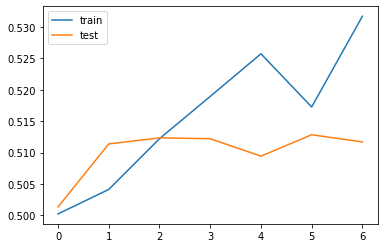

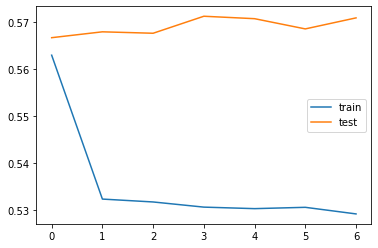

Accuracy: 74.71%
AUC: 51.24%
AUC: 51.24%
*************  TRAINING WITH GRU *********************
Epoch 1/7
81/81 - 5s - loss: 0.5869 - auc: 0.5002 - val_loss: 0.5754 - val_auc: 0.5251 - 5s/epoch - 57ms/step
Epoch 2/7
81/81 - 1s - loss: 0.5353 - auc: 0.5071 - val_loss: 0.5733 - val_auc: 0.5154 - 1s/epoch - 16ms/step
Epoch 3/7
81/81 - 1s - loss: 0.5338 - auc: 0.5089 - val_loss: 0.5717 - val_auc: 0.5188 - 1s/epoch - 16ms/step
Epoch 4/7
81/81 - 1s - loss: 0.5325 - auc: 0.5154 - val_loss: 0.5716 - val_auc: 0.5208 - 1s/epoch - 16ms/step
Epoch 5/7
81/81 - 1s - loss: 0.5316 - auc: 0.5300 - val_loss: 0.5719 - val_auc: 0.5226 - 1s/epoch - 17ms/step
Epoch 6/7
81/81 - 1s - loss: 0.5310 - auc: 0.5174 - val_loss: 0.5720 - val_auc: 0.5267 - 1s/epoch - 16ms/step
Epoch 7/7
81/81 - 1s - loss: 0.5302 - auc: 0.5284 - val_loss: 0.5734 - val_auc: 0.5274 - 1s/epoch - 16ms/step


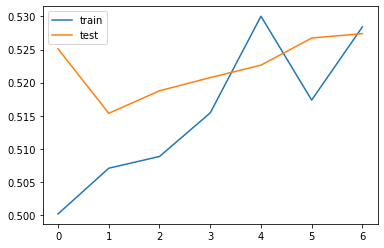

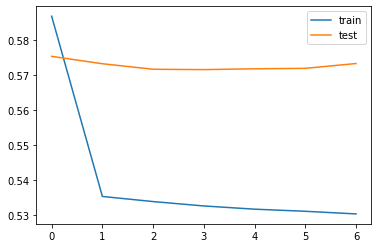

Accuracy: 74.64%
AUC: 53.09%
AUC: 53.09%


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, auc,roc_auc_score, precision_recall_fscore_support, confusion_matrix, f1_score

############################################## Read Data ##############################################

df = pd.read_csv("/content/drive/MyDrive/Data.csv")
df = df.dropna(how='any',axis=0) 

############################################## Data Cleaning ##############################################


df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%Y-%m-%d %H:%M:%S') 

days = timedelta(9)
df['InvoiceDate'] = df['InvoiceDate'] - days

df['month_wise'] = [ (dt.year*100) + (dt.month ) for dt in df.InvoiceDate]
df['day_wise'] = [ (dt.year*10000) + (dt.month *100) + (dt.day) for dt in df.InvoiceDate]

df['spend'] = df.Price * df.Quantity

df['Postage'] = np.where(df.StockCode == 'POST', 'Postage','No_Postage')

df['cancel'] = df.Invoice.str[0]
df.loc[df.cancel != 'C','cancel'] = 'P'

df_cancel = df[df.cancel == 'C']
df_purchase = df[df.cancel == 'P']


############################################## Feature Engineering ##############################################

# Total Invoices per month
No_Monthly_Invoices = df.groupby(['Customer ID','month_wise'], as_index =False)['Invoice'].aggregate(pd.Series.nunique)
No_Monthly_Invoices.rename(columns = {'Invoice':'Count_All_Invoice'}, inplace = True)

No_Monthly_Purchase_Invoices = df_purchase.groupby(['Customer ID','month_wise'], as_index=False)['Invoice'].aggregate(pd.Series.nunique)
No_Monthly_Purchase_Invoices.rename(columns = {'Invoice':'Count_Purchase_Invoice'}, inplace = True)

No_Monthly_Cancel_Invoices = df_cancel.groupby(['Customer ID','month_wise'], as_index=False)['Invoice'].aggregate(pd.Series.nunique)
No_Monthly_Cancel_Invoices.rename(columns = {'Invoice':'Count_Cancel_Invoice'}, inplace = True)

# Total Invoices per day
No_Daily_Invoices = df.groupby(['Customer ID','month_wise','day_wise'], as_index =False)['Invoice'].aggregate(pd.Series.nunique)
No_Daily_Purchase_Invoices = df_purchase.groupby(['Customer ID','month_wise','day_wise'], as_index=False)['Invoice'].aggregate(pd.Series.nunique)
No_Daily_Cancel_Invoices = df_cancel.groupby(['Customer ID','month_wise','day_wise'], as_index=False)['Invoice'].aggregate(pd.Series.nunique)

# Aggregating No_Daily_Purchase_Invoices and No_Daily_Cancel_Invoices with creating new columns Invoice_Purchase and Invoice_Cancel
No_Daily_Net_Purchase_Invoices = pd.merge(No_Daily_Purchase_Invoices, No_Daily_Cancel_Invoices, how = 'outer', on = ['Customer ID','month_wise','day_wise'], suffixes = ['_Purchase','_Cancel'])
No_Daily_Net_Purchase_Invoices.fillna(0, inplace = True)

# Create Net Purchase column
No_Daily_Net_Purchase_Invoices['Invoice_Net_Purchase'] = No_Daily_Net_Purchase_Invoices.Invoice_Purchase - No_Daily_Net_Purchase_Invoices.Invoice_Cancel

Avg_Daily_Invoices = No_Daily_Net_Purchase_Invoices.groupby(['Customer ID','month_wise'], as_index=False).aggregate({'Invoice_Purchase':np.mean,'Invoice_Cancel':np.mean,'Invoice_Net_Purchase':np.mean})
Avg_Daily_Invoices.rename(columns = {'Invoice_Purchase':'Daily_avg_Count_Purchase_Invoice', 'Invoice_Cancel' :'Daily_avg_Count_Cancel_Invoice', 'Invoice_Net_Purchase' : 'Daily_avg_Count_Net_Purchase_Invoice'}, inplace = True)

# Total Spend per month
Total_Purchase_spend = df_purchase.groupby(['Customer ID', 'month_wise'] , as_index=False)['spend'].agg(sum)
Total_Purchase_spend.rename(columns = {'spend':'Total_Purchase_spend'}, inplace = True)

Total_Cancel_spend = df_cancel.groupby(['Customer ID', 'month_wise'], as_index=False)['spend'].agg(sum)
Total_Cancel_spend.rename(columns = {'spend':'Total_Cancel_spend'}, inplace = True)

Total_Net_spend = df.groupby(['Customer ID', 'month_wise'] , as_index=False)['spend'].agg(sum)
Total_Net_spend.rename(columns = {'spend':'Total_Net_spend'}, inplace = True)

# Total Spend per day
Total_Daily_Purchase_spend = df_purchase.groupby(['Customer ID', 'month_wise', 'day_wise'], as_index=False)['spend'].aggregate(sum)
Total_Daily_Cancel_spend = df_cancel.groupby(['Customer ID', 'month_wise', 'day_wise'], as_index=False)['spend'].aggregate(sum)
Total_Daily_Net_spend = pd.merge(Total_Daily_Purchase_spend, Total_Daily_Cancel_spend, how = 'outer', on = ['Customer ID','month_wise','day_wise'], suffixes = ['_Purchase','_Cancel'])
Total_Daily_Net_spend.fillna(0, inplace = True)
Total_Daily_Net_spend['Net_spend'] = Total_Daily_Net_spend.spend_Purchase + Total_Daily_Net_spend.spend_Cancel

# Average daily spend
Avg_Daily_Net_spend = Total_Daily_Net_spend.groupby(['Customer ID','month_wise'], as_index =False).aggregate({'spend_Purchase':np.mean,'spend_Cancel':np.mean,'Net_spend':np.mean})
Avg_Daily_Net_spend.rename(columns = {'spend_Purchase':'Avg_Daily_Purchase_Spend', 'spend_Cancel': 'Avg_Daily_Cancel_Spend','Net_spend' : 'Avg_Daily_Net_Spend'}, inplace = True)

# Monthwise Cancel/Purchase ratio
Cancel_Purchase_ratio = Total_Daily_Net_spend.groupby(['Customer ID','month_wise'], as_index= False).agg({'spend_Purchase':sum,'spend_Cancel':sum,'Net_spend':sum})

Cancel_Purchase_ratio['c_p_ratio'] = np.abs(Cancel_Purchase_ratio.spend_Cancel / Cancel_Purchase_ratio.spend_Purchase)

Cancel_Purchase_ratio.loc[Cancel_Purchase_ratio.c_p_ratio.isin(['inf']),'c_p_ratio'] = 0
Cancel_Purchase_ratio.rename(columns = {'spend_Purchase':'Total_Purchase_spend', 'spend_Cancel':'Total_Cancel_spend', 'Net_spend':'Total_Net_spend'}, inplace = True)

# postage/spend in Purchase
postage_Purchase =  df_purchase.groupby(['Customer ID', 'month_wise', 'Postage'], as_index = False)['spend'].agg(sum)

postage_Purchase1 = pd.pivot_table(postage_Purchase, values = ['spend'] , index = ['Customer ID', 'month_wise'],columns=['Postage'], aggfunc= sum, fill_value=0)
postage_Purchase1.reset_index(inplace = True)
postage_Purchase1.columns = ['Customer ID', 'month_wise', 'Spend_Items','Spend_Postage']

postage_Purchase1['Post_Spend_ratio'] = postage_Purchase1['Spend_Postage'] / postage_Purchase1['Spend_Items']

postage_Purchase1.loc[postage_Purchase1.Post_Spend_ratio.isin(['inf']),'Post_Spend_ratio'] = 0


# postage/spend in cancellations
postage_cancel =  df_cancel.groupby(['Customer ID', 'month_wise', 'Postage'], as_index = False)['spend'].agg(sum)

postage_cancel1 = pd.pivot_table(postage_cancel, values = ['spend'] , index = ['Customer ID', 'month_wise'],columns=['Postage'], aggfunc= sum, fill_value=0)
postage_cancel1.reset_index(inplace = True)
postage_cancel1.columns = ['Customer ID', 'month_wise', 'Spend_Items','Spend_Postage']
postage_cancel1['Post_Spend_ratio'] = np.abs(postage_cancel1['Spend_Postage'] / postage_cancel1['Spend_Items'])

postage_cancel1.loc[postage_cancel1.Post_Spend_ratio.isin(['inf']),'Post_Spend_ratio'] = 0

# Number of items in each invoice
Total_Invoice_Purchase_items = df_purchase.groupby(['Customer ID','month_wise','Invoice'], as_index =False)['Quantity'].aggregate(sum)
Total_Invoice_Cancel_items = df_cancel.groupby(['Customer ID','month_wise','Invoice'], as_index =False)['Quantity'].aggregate(sum)
Total_Invoice_Net_items = pd.merge(Total_Invoice_Purchase_items, Total_Invoice_Cancel_items, how = 'outer', on = ['Customer ID','month_wise','Invoice'], suffixes = ['_Purchase','_Cancel'] )

Total_Invoice_Net_items.fillna(0, inplace = True)

Total_Invoice_Net_items['Net_Quantity'] = Total_Invoice_Net_items.Quantity_Purchase + Total_Invoice_Net_items.Quantity_Cancel


# Average items in each invoice
Avg_Invoice_Net_items = Total_Invoice_Net_items.groupby(['Customer ID','month_wise'], as_index =False).aggregate({'Quantity_Purchase':np.mean,'Quantity_Cancel':np.mean,'Net_Quantity':np.mean})
Avg_Invoice_Net_items.rename(columns = {'Quantity_Purchase':'Avg_Daily_Purchase_Quantity', 'Quantity_Cancel': 'Avg_Daily_Cancel_Quantity','Net_Quantity' : 'Avg_Daily_Net_Quantity'}, inplace = True)

Avg_Invoice_Net_items['Items_retention_ratio'] = Avg_Invoice_Net_items['Avg_Daily_Net_Quantity'] / Avg_Invoice_Net_items['Avg_Daily_Purchase_Quantity']

Avg_Invoice_Net_items.loc[Avg_Invoice_Net_items.Items_retention_ratio.isin(['inf', '-inf']),'Items_retention_ratio'] = 0

# Creating a DF that defines the structure of input data

cust = df['Customer ID'].unique()
months = df['month_wise'].unique()
month_wise = []
for i in range(0, len(cust)):
    for j in months:
        month_wise.append(j)

cust1 = [c for c in cust for k in range(0, len(months))]
cust_month = pd.DataFrame({'Customer ID': cust1, 'month_wise':month_wise})

# Calculating months since last Purchase
cust_month['month_last_Purchase'] = 190001

for cu in cust:
    Purchase_month_list = list(No_Monthly_Purchase_Invoices.loc[No_Monthly_Purchase_Invoices['Customer ID'] == cu,'month_wise'])
    Purchase_month_list.append(201111)
    for i in range(len(Purchase_month_list)-1):
        start = Purchase_month_list[i]
        end = Purchase_month_list[i+1]      
        cust_month.loc[(cust_month['Customer ID'] == cu) & (cust_month.month_wise >= start) & (cust_month.month_wise < end), 'month_last_Purchase'] = start
        
        
cust_month['month_wise1'] = [str(x)[0:4]+str('-') + str(x)[4:6]+str('-')+str('01') for x in cust_month.month_wise]
        
cust_month['month_last_Purchase1'] = [str(x)[0:4]+str('-') + str(x)[4:6]+str('-')+str('01') for x in cust_month.month_last_Purchase]

cust_month['month_wise1'] = pd.to_datetime(cust_month['month_wise1'])        
cust_month['month_last_Purchase1'] = pd.to_datetime(cust_month['month_last_Purchase1'])    

cust_month['months_since_last_Purchase'] = cust_month.month_wise1 - cust_month.month_last_Purchase1

cust_month['months_since_last_Purchase1'] = [x.days/30 for x in cust_month.months_since_last_Purchase]
cust_month['months_since_last_Purchase1'] = cust_month['months_since_last_Purchase1'].round(0)
cust_month.loc[cust_month.months_since_last_Purchase1> 100, 'months_since_last_Purchase1'] = 999
   
cust_month = cust_month[['Customer ID', 'month_wise', 'months_since_last_Purchase1']]

cust_month.columns = ['Customer ID', 'month_wise', 'months_since_last_Purchase']

# Merging the data
combined_df = pd.merge(No_Monthly_Invoices, No_Monthly_Purchase_Invoices,how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'] )
combined_df = pd.merge(combined_df, No_Monthly_Cancel_Invoices,how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'] )
combined_df = pd.merge(cust_month , combined_df, how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'] )

combined_df['Count_Net_Purchase_Invoice'] = combined_df.Count_Purchase_Invoice - combined_df.Count_Cancel_Invoice

# Merging new feature set 2 (Daily average counts)
combined_df = pd.merge(combined_df, Avg_Daily_Invoices ,how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'])

# Merging new feature set 3 (Spend Variables)
combined_df = pd.merge(combined_df, Avg_Daily_Net_spend ,how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'] )

# Merging feature set 4(Total spend and cancel : spend ratio)
combined_df = pd.merge(combined_df, Cancel_Purchase_ratio ,how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'] )

# Merging new feature set 5 (Postage Variables)
combined_df = pd.merge(combined_df, postage_Purchase1 ,how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'] )

# Merging new feature set 6 (Postage on cancellations)
combined_df = pd.merge(combined_df, postage_cancel1 ,how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'], suffixes = ['_on_Purchase','_on_Cancel'])

# Merging new feature set 7 (Avg_Invoice_Net_items)
combined_df = pd.merge(combined_df, Avg_Invoice_Net_items ,how = 'outer', left_on = ['Customer ID', 'month_wise'] , right_on = ['Customer ID', 'month_wise'])

# Filling all NA with 0
combined_df.fillna(0, inplace =True)

combined_df.replace([np.inf, -np.inf], 0, inplace=True)

# Removing Data of 1st month (as it has only 9 days of Data)
min_month = combined_df.month_wise.unique()[0]
combined_df = combined_df[combined_df.month_wise != min_month]

# Standardization of the Values

scaler = StandardScaler()
# Excluding last 2 months of data from train data
month_filter = combined_df.month_wise.unique()[-2]

train_data_subset = combined_df.loc[combined_df.month_wise < month_filter]

train_data_subset = train_data_subset.iloc[:,2:]


#Fit only on the data to be used for training
scaler.fit(train_data_subset)

#Transform the entire dataset using parameters calculated on Train data
all_data_scaled = scaler.transform(combined_df.iloc[:,2:])

#LSTM Takes input in the form of Samples, timesteps, features
num_samples =  len(combined_df['Customer ID'].unique())
time_steps = len(combined_df['month_wise'].unique())
num_variables = combined_df.shape[1]-2

# Converting DF to array
#arr = combined_df.iloc[:,-num_variables:].values.reshape((num_samples, time_steps, num_variables))
arr = all_data_scaled.reshape((num_samples, time_steps, num_variables))


# Creating train_Y variable - Label
data_train = df[df.month_wise == 201109]
data_train_Purchase = data_train[data_train.cancel == 'P']

# all customer who shopped in the last month are considered as class 1 for testing
cust_list_train = Purchase_cust = list(data_train_Purchase['Customer ID'].unique())
label = [1 for k in range(0, len(Purchase_cust))]

all_cust = list(set(list(df['Customer ID'].unique())))

#remaining are considered as class 0
Remaining_cust = list(set(all_cust) - set(Purchase_cust))
label_0 = [0 for k in range(0, len(Remaining_cust))]

cust_list_train.extend(Remaining_cust)
label.extend(label_0)

cust_label_train = pd.DataFrame({'Customer ID' : cust_list_train, 'label':label})
cust_label_train.sort_values(by = 'Customer ID', axis = 0, ascending = True, inplace = True)

# Creating test_Y variable - Label
data_test = df[df.month_wise == 201110]
data_test_Purchase = data_test[data_test.cancel == 'P']

# all customer who shopped in the last month are considered as class 1 for testing
cust_list_test = Purchase_cust = list(data_test_Purchase['Customer ID'].unique())
label = [1 for k in range(0, len(Purchase_cust))]

all_cust = list(set(list(df['Customer ID'].unique())))

#remaining are considered as class 0
Remaining_cust = list(set(all_cust) - set(Purchase_cust))
label_0 = [0 for k in range(0, len(Remaining_cust))]

cust_list_test.extend(Remaining_cust)
label.extend(label_0)

cust_label_test = pd.DataFrame({'Customer ID' : cust_list_test, 'label':label})
cust_label_test.sort_values(by = 'Customer ID', axis = 0, ascending = True, inplace = True)


# Defining Train and test Training on data from month 1 to month 22, Predicting on month 23 Testing on data from month 2 to month 23, predicting on month 24

train_X = arr[:,0:21,:]
train_Y = np.array(cust_label_train.label)
val_X = arr[:,1:22,:]
val_Y =  np.array(cust_label_test.label)


# Define the network

# design network
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
# fit network
history = model.fit(train_X, train_Y, epochs=7, batch_size=72, validation_data=(val_X, val_Y), verbose=2, shuffle=True)

# plot history of AUC
pyplot.plot(history.history['auc'], label='train')
pyplot.plot(history.history['val_auc'], label='test')
pyplot.legend()
pyplot.show()


# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

prob_next_mon_Purchase = model.predict(val_X)

val_Y_pred = prob_next_mon_Purchase.round()
accuracy = accuracy_score(val_Y, val_Y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

AUC = roc_auc_score(val_Y, prob_next_mon_Purchase)
print("AUC: %.2f%%" % (AUC * 100.0))

confusion_matrix(val_Y, val_Y_pred)
precision_recall_fscore_support(val_Y, val_Y_pred)
    

cutoff = [x/100 for x in range(0,105,5)]
f1 = []
for c in cutoff:
    val_Y_pred = np.where(prob_next_mon_Purchase < c, 0,1)
    f1_sc = f1_score(val_Y, val_Y_pred)
    f1.append(f1_sc)
cutoff_idx = f1.index(max(f1))    
best_cutoff = cutoff[cutoff_idx]

# evaluate predictions for best cutoff
val_Y_pred = np.where(prob_next_mon_Purchase < best_cutoff, 0,1)

AUC = roc_auc_score(val_Y, prob_next_mon_Purchase) #AUC Remains same
print("AUC: %.2f%%" % (AUC * 100.0))

confusion_matrix(val_Y, val_Y_pred)
f1_score(val_Y, val_Y_pred)

# Latest_data for prediction
final_test_X = arr[:,2:23,:]
prob_next_mon_Purchase = model.predict(final_test_X)
   
prediction = pd.DataFrame()
prediction['Customer ID'] = df['Customer ID'].unique()
prediction['Prediction'] = prob_next_mon_Purchase

prediction.to_csv(r'submission_LSTM.csv')


# GRU
print("*************  TRAINING WITH GRU *********************")
model2 = Sequential()
model2.add(GRU(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

history = model2.fit(train_X, train_Y, epochs=7, batch_size=72, validation_data=(val_X, val_Y), verbose=2, shuffle=True)

# plot history of AUC
pyplot.plot(history.history['auc'], label='train')
pyplot.plot(history.history['val_auc'], label='test')
pyplot.legend()
pyplot.show()


# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

prob_next_mon_Purchase = model2.predict(val_X)

val_Y_pred = prob_next_mon_Purchase.round()
accuracy = accuracy_score(val_Y, val_Y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

AUC = roc_auc_score(val_Y, prob_next_mon_Purchase)
print("AUC: %.2f%%" % (AUC * 100.0))

confusion_matrix(val_Y, val_Y_pred)
precision_recall_fscore_support(val_Y, val_Y_pred)
    

cutoff = [x/100 for x in range(0,105,5)]
f1 = []
for c in cutoff:
    val_Y_pred = np.where(prob_next_mon_Purchase < c, 0,1)
    f1_sc = f1_score(val_Y, val_Y_pred)
    f1.append(f1_sc)
cutoff_idx = f1.index(max(f1))    
best_cutoff = cutoff[cutoff_idx]

# evaluate predictions for best cutoff
val_Y_pred = np.where(prob_next_mon_Purchase < best_cutoff, 0,1)

AUC = roc_auc_score(val_Y, prob_next_mon_Purchase) #AUC Remains same
print("AUC: %.2f%%" % (AUC * 100.0))

confusion_matrix(val_Y, val_Y_pred)
f1_score(val_Y, val_Y_pred)

# Latest_data for prediction
final_test_X = arr[:,2:23,:]
prob_next_mon_Purchase = model2.predict(final_test_X)
   
prediction = pd.DataFrame()
prediction['Customer ID'] = df['Customer ID'].unique()
prediction['Prediction'] = prob_next_mon_Purchase

prediction.to_csv(r'submission_GRU.csv')



In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20)                2820      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,841
Trainable params: 2,841
Non-trainable params: 0
_________________________________________________________________
